### Введение
С развитием LLM-моделей спрашивать теоретическую часть или короткие алгоритмы и принципы стало бесполезно, поэтому задание будет одно, но комплексное и приближенное к реальности.

Вы можете использовать любые LLM-модели и Copilot для написания кода, так как в реальной работе сотрудники отдела также имеют доступ ко всем современным инструментам (Sonnet 3.5, GPT-4o, GitHub Copilot и т. п.).

В задании вы будете работать с тестовыми данными по банкоматам и API ЦБ РФ для получения ключевой ставки.

---

### Специфика данных fees
`fees` — тарифы за обслуживание банкомата инкассаторами. Так как банкоматы могут находиться в разных регионах, тарифы у них могут отличаться.

- **CashDeliveryFixedFee** — фиксированная стоимость доставки наличных (не зависит от суммы).
- **CashDeliveryPercentageFee** — процент от суммы доставленных наличных. Он добавляется к фиксированной стоимости. Если в таблице указано `0.0001`, это значит 0.01% от суммы.
- **CashDeliveryMinFee** — минимальная сумма, которую с нас возьмут по `CashDeliveryPercentageFee`. Например, если мы попросим инкассаторов в ATM_4 довезти всего 10 000 рублей, то с нас возьмут 5250 рублей (фиксированная стоимость), а так как `10 000 * 0.04% < 450 рублей`, то дополнительно возьмут ещё 450 рублей. Итог: 5250 + 450 рублей.

**CashCollection** — это пример сложного тарифа, который учитывает специфику работы с банкоматом. В банкомат деньги не докладывают, а меняют сразу кассету. Есть провайдеры, которые тарифицируют не только доставку, но и пересчёт денег в извлечённой кассете. Например, в ATM_4 у нас именно такой тариф.  
Пример: у нас в банкомате осталось 500 тыс. рублей, а мы хотим, чтобы у него был баланс 2 млн. Тогда мы заказываем довезти кассету на 2 млн. и платим по тарифу за доставку. При доставке старая кассета извлекается, и мы также по тарифу платим за пересчёт 500 тыс. рублей (0.45%, но не менее 1140 рублей).

- **CashCollectionFixedFee** — фиксированная стоимость за извлечение старой кассеты (в данных примерах нулевая).
- **CashCollectionPercentageFee** — процент от суммы извлечённой кассеты.
- **CashCollectionMinFee** — минимальная сумма, которую с нас возьмут по `CashCollectionPercentageFee`.

---

### Специфика данных transactions
Таблица содержит данные по снятиям, пополнениям (инкассациям) и балансу банкомата на конец дня.  
Считаем, что банкоматы в начале года пустые и не работали, поэтому баланс на конец дня равен 0, пока не случится первая инкассация.

- **bal_end_of_day** — баланс на конец дня.
- **cash_in** — пополнение в результате инкассации.
- **cash_out** — снятие наличных клиентами.

---

### Изучение данных

In [1]:
import pandas as pd
import requests
import matplotlib.pyplot as plt

In [2]:
# Забираем данные по тарфиам на обслуживание банкоматов
fees = pd.read_parquet('https://storage.yandexcloud.net/norvpublic/fees.parquet')
# статистика операция по дням.
transactions = pd.read_parquet('https://storage.yandexcloud.net/norvpublic/transactions.parquet')

In [3]:
fees.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ATM_ID                       4 non-null      string 
 1   CashDeliveryFixedFee         4 non-null      float64
 2   CashDeliveryPercentageFee    4 non-null      float64
 3   CashDeliveryMinFee           2 non-null      float64
 4   CashCollectionFixedFee       1 non-null      float64
 5   CashCollectionPercentageFee  1 non-null      float64
 6   CashCollectionMinFee         1 non-null      float64
dtypes: float64(6), string(1)
memory usage: 352.0 bytes


In [4]:
fees

,ATM_ID,CashDeliveryFixedFee,CashDeliveryPercentageFee,CashDeliveryMinFee,CashCollectionFixedFee,CashCollectionPercentageFee,CashCollectionMinFee
0,ATM_1,1365.0,0.0001,NaN,NaN,NaN,NaN
1,ATM_2,1365.0,0.0001,NaN,NaN,NaN,NaN
2,ATM_4,5250.0,0.0004,450.0,0.0,0.0045,1140.0
3,ATM_3,2250.0,0.0001,675.0,NaN,NaN,NaN


---

В данном случае NaN означает, что провайдеры не тарифицируют данные услуги, либо отсутствуют минимальные стоимости услуг по данному тарифу, поэтому смело можно заполнить пропуски нулями

---

In [5]:
fees = fees.fillna(0)

In [6]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1176 entries, 0 to 1175
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype                  
---  ------          --------------  -----                  
 0   date            1176 non-null   datetime64[ms, Etc/UTC]
 1   ATM_ID          1176 non-null   string                 
 2   bal_end_of_day  1176 non-null   float64                
 3   cash_in         1176 non-null   float64                
 4   cash_out        1176 non-null   float64                
dtypes: datetime64[ms, Etc/UTC](1), float64(3), string(1)
memory usage: 46.1 KB


---

Пропусков в таблице нет, все в порядке

---


In [7]:
transactions.describe()

,bal_end_of_day,cash_in,cash_out
count,1.176000e+03,1.176000e+03,1.176000e+03
mean,2.879257e+06,2.758759e+05,2.124446e+05
std,1.905111e+06,1.315979e+06,3.188842e+05
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.200650e+06,0.000000e+00,0.000000e+00
50%,2.575200e+06,0.000000e+00,4.007500e+04
75%,4.500625e+06,0.000000e+00,3.263000e+05
max,7.119900e+06,7.120000e+06,1.909800e+06


---

Выбросов и аномалий в данных не замечено

---


In [8]:
date_description = transactions['date'].describe()

print(date_description)

count                         1176
mean     2024-06-06 12:00:00+00:00
min      2024-01-12 00:00:00+00:00
25%      2024-03-25 00:00:00+00:00
50%      2024-06-06 12:00:00+00:00
75%      2024-08-19 00:00:00+00:00
max      2024-10-31 00:00:00+00:00
Name: date, dtype: object


In [9]:
transactions['date'].unique()

<DatetimeArray>
['2024-01-12 00:00:00+00:00', '2024-01-13 00:00:00+00:00',
 '2024-01-14 00:00:00+00:00', '2024-01-15 00:00:00+00:00',
 '2024-01-16 00:00:00+00:00', '2024-01-17 00:00:00+00:00',
 '2024-01-18 00:00:00+00:00', '2024-01-19 00:00:00+00:00',
 '2024-01-20 00:00:00+00:00', '2024-01-21 00:00:00+00:00',
 ...
 '2024-10-22 00:00:00+00:00', '2024-10-23 00:00:00+00:00',
 '2024-10-24 00:00:00+00:00', '2024-10-25 00:00:00+00:00',
 '2024-10-26 00:00:00+00:00', '2024-10-27 00:00:00+00:00',
 '2024-10-28 00:00:00+00:00', '2024-10-29 00:00:00+00:00',
 '2024-10-30 00:00:00+00:00', '2024-10-31 00:00:00+00:00']
Length: 294, dtype: datetime64[ms, Etc/UTC]

---

Данные представлены в промежуток от 01.12.2024 по 31.10.2024

---


In [10]:
transactions[transactions['cash_in'] > 0].head(10)

,date,ATM_ID,bal_end_of_day,cash_in,cash_out
21,2024-01-17 00:00:00+00:00,ATM_2,7119900.0,7120000.0,100.0
23,2024-01-17 00:00:00+00:00,ATM_4,1630000.0,1630000.0,0.0
29,2024-01-19 00:00:00+00:00,ATM_2,6072400.0,7120000.0,1047600.0
42,2024-01-22 00:00:00+00:00,ATM_3,5609800.0,5610000.0,200.0
44,2024-01-23 00:00:00+00:00,ATM_1,6525100.0,6620000.0,94900.0
77,2024-01-31 00:00:00+00:00,ATM_2,6291800.0,7120000.0,828200.0
100,2024-02-06 00:00:00+00:00,ATM_1,5974000.0,6620000.0,646000.0
109,2024-02-08 00:00:00+00:00,ATM_2,6415700.0,7120000.0,704300.0
128,2024-02-13 00:00:00+00:00,ATM_1,6396300.0,6620000.0,223700.0
157,2024-02-20 00:00:00+00:00,ATM_2,6342000.0,7120000.0,778000.0


Учитывая, что копейки в обороте АТМ отсутствуют, можно изменить тип данных в некоторых столбцах таблицы на целочисленный

In [11]:
columns = ['bal_end_of_day', 'cash_in', 'cash_out']
transactions[columns] = transactions[columns].astype(int)

In [12]:
transactions.describe()

,bal_end_of_day,cash_in,cash_out
count,1.176000e+03,1.176000e+03,1.176000e+03
mean,2.879257e+06,2.758759e+05,2.124446e+05
std,1.905111e+06,1.315979e+06,3.188842e+05
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.200650e+06,0.000000e+00,0.000000e+00
50%,2.575200e+06,0.000000e+00,4.007500e+04
75%,4.500625e+06,0.000000e+00,3.263000e+05
max,7.119900e+06,7.120000e+06,1.909800e+06


Распределение не поменялось, все в порядке

### Часть 1 — упущенный процентный доход

Специалисту по ML важно уметь получать данные с различных API и читать документацию. Для расчёта упущенного процентного дохода нужно обратиться к API ЦБ РФ и получить динамику ключевой ставки за 2024 год.

https://www.cbr.ru/DailyInfoWebServ/DailyInfo.asmx?op=KeyRate

Для запроса к API не нужен токен и регистрация. ЦБ РФ для части данных предпочитает использовать SOAP.

Учитывая, что хранить наличные деньги в банкомате — не самое удачное инвестиционное решение, посчитайте упущенный процентный доход для каждого банкомата. Рассчитываем, что банк мог бы вложить эти деньги и получить доход, равный ключевой ставке ЦБ РФ, актуальной на день баланса банкомата. Добавьте к таблице `transactions` столбец с упущенной процентной выгодой.


Осуществим XML-запрос на сервер ЦБ РФ

In [13]:
soap_request = """<?xml version="1.0" encoding="utf-8"?>
<soap:Envelope xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xmlns:xsd="http://www.w3.org/2001/XMLSchema" xmlns:soap="http://schemas.xmlsoap.org/soap/envelope/">
  <soap:Body>
    <KeyRate xmlns="http://web.cbr.ru/">
      <fromDate>2024-01-12</fromDate>
      <ToDate>2024-10-31</ToDate>
    </KeyRate>
  </soap:Body>
</soap:Envelope>
"""

url = "http://www.cbr.ru/DailyInfoWebServ/DailyInfo.asmx"
headers = {
    'Content-Type': 'text/xml; charset=utf-8',
    'Content-Length': str(len(soap_request.encode('utf-8'))),
    'SOAPAction': "http://web.cbr.ru/KeyRate"
}

response = requests.post(url, data=soap_request, headers=headers)

if response.status_code == 200:

    import xml.etree.ElementTree as ET

    root = ET.fromstring(response.content)
    namespace = {
        'soap': 'http://schemas.xmlsoap.org/soap/envelope/',
        'xsd': 'http://www.w3.org/2001/XMLSchema',
        'diffgr': 'urn:schemas-microsoft-com:xml-diffgram-v1',
        'msdata': 'urn:schemas-microsoft-com:xml-msdata',
        'cbr': 'http://web.cbr.ru/'}

    key_rate_results = root.findall('.//cbr:KeyRateResult/diffgr:diffgram/KeyRate/KR', namespace)

    rate = []
    date = []
    for kr in key_rate_results:
        date.append(kr.find('DT').text[:-6] + '+00:00') #преобразуем в формат аналогичный таблице transactions (ключевая ставка не поменяется)
        rate.append(float(kr.find('Rate').text))
        dictionare = {'key_rate':rate[::-1], 'date':date[::-1]}
    # Создаем DataFrame
    key_rate = pd.DataFrame(dictionare)
else:
    print(f"Error: {response.status_code} - {response.text}")

In [14]:
key_rate['date'] = pd.to_datetime(key_rate['date'])

Видны пропуски дат на субботу и воскресенье. Заполним их значением пятницы

In [15]:
full_range = pd.date_range(start=key_rate['date'].min(), end=key_rate['date'].max(), freq='D')
key_rate = pd.DataFrame(full_range, columns=['date']).merge(key_rate, on='date', how='left')
key_rate['key_rate'] = key_rate['key_rate'].ffill()

In [16]:
key_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype              
---  ------    --------------  -----              
 0   date      294 non-null    datetime64[ns, UTC]
 1   key_rate  294 non-null    float64            
dtypes: datetime64[ns, UTC](1), float64(1)
memory usage: 4.7 KB


In [17]:
key_rate.head(10)

,date,key_rate
0,2024-01-12 00:00:00+00:00,16.0
1,2024-01-13 00:00:00+00:00,16.0
2,2024-01-14 00:00:00+00:00,16.0
3,2024-01-15 00:00:00+00:00,16.0
4,2024-01-16 00:00:00+00:00,16.0
5,2024-01-17 00:00:00+00:00,16.0
6,2024-01-18 00:00:00+00:00,16.0
7,2024-01-19 00:00:00+00:00,16.0
8,2024-01-20 00:00:00+00:00,16.0
9,2024-01-21 00:00:00+00:00,16.0


Число дат теперь соответствует df transactions

In [18]:
transactions = transactions.merge(key_rate, on='date', how='left')

Добавим столбец с упущенной выгодой. Это будет баланс * (годовая ключевая ставка / 100) * (1/365)

In [19]:
transactions['missed_income'] = transactions['bal_end_of_day'] * (transactions['key_rate'] / 100) * (1 / 365)

In [20]:
#transactions = transactions.drop('key_rate', axis=1)

In [21]:
transactions[transactions['missed_income']>0].head()

,date,ATM_ID,bal_end_of_day,cash_in,cash_out,key_rate,missed_income
21,2024-01-17 00:00:00+00:00,ATM_2,7119900,7120000,100,16.0,3121.052055
23,2024-01-17 00:00:00+00:00,ATM_4,1630000,1630000,0,16.0,714.520548
25,2024-01-18 00:00:00+00:00,ATM_2,7104600,0,15300,16.0,3114.345205
27,2024-01-18 00:00:00+00:00,ATM_4,1630000,0,0,16.0,714.520548
29,2024-01-19 00:00:00+00:00,ATM_2,6072400,7120000,1047600,16.0,2661.873973


Требуемый столбец добавлен

### Часть 2 - расходы на инкассацию

Теперь к данным по банкоматам, кроме упущенного процентного дохода, необходимо добавить столбец расходов на инкассацию. Для простоты считаем, что мы не платим за аренду помещения и страхование, поэтому нам достаточно данных по тарифам на инкассацию (`fees`).

In [22]:
transactions = transactions.merge(fees, on='ATM_ID', how='left')

In [23]:
def calculate_cash_delivery_fees(row):
    cash_in = row['cash_in']
    fixed_fee = row['CashDeliveryFixedFee']
    percentage_fee = cash_in * row['CashDeliveryPercentageFee']
    min_fee = row['CashDeliveryMinFee']

    cash_out = row['bal_end_of_day']
    fixed_fee_col = row['CashCollectionFixedFee']
    percentage_fee_col = cash_out * row['CashCollectionPercentageFee']
    min_fee_col = row['CashCollectionMinFee']

    if cash_in > 0:
        total_delivery_fee = fixed_fee + max(percentage_fee, min_fee) + fixed_fee_col + max(percentage_fee_col, min_fee_col)
    else:
        total_delivery_fee = 0
    return total_delivery_fee

In [24]:
transactions['collection_costs'] = transactions.apply(calculate_cash_delivery_fees, axis=1)

In [25]:
transactions[transactions['collection_costs']>0].head(10)

,date,ATM_ID,bal_end_of_day,cash_in,cash_out,key_rate,missed_income,CashDeliveryFixedFee,CashDeliveryPercentageFee,CashDeliveryMinFee,CashCollectionFixedFee,CashCollectionPercentageFee,CashCollectionMinFee,collection_costs
21,2024-01-17 00:00:00+00:00,ATM_2,7119900,7120000,100,16.0,3121.052055,1365.0,0.0001,0.0,0.0,0.0000,0.0,2077.0
23,2024-01-17 00:00:00+00:00,ATM_4,1630000,1630000,0,16.0,714.520548,5250.0,0.0004,450.0,0.0,0.0045,1140.0,13237.0
29,2024-01-19 00:00:00+00:00,ATM_2,6072400,7120000,1047600,16.0,2661.873973,1365.0,0.0001,0.0,0.0,0.0000,0.0,2077.0
42,2024-01-22 00:00:00+00:00,ATM_3,5609800,5610000,200,16.0,2459.090411,2250.0,0.0001,675.0,0.0,0.0000,0.0,2925.0
44,2024-01-23 00:00:00+00:00,ATM_1,6525100,6620000,94900,16.0,2860.317808,1365.0,0.0001,0.0,0.0,0.0000,0.0,2027.0
77,2024-01-31 00:00:00+00:00,ATM_2,6291800,7120000,828200,16.0,2758.049315,1365.0,0.0001,0.0,0.0,0.0000,0.0,2077.0
100,2024-02-06 00:00:00+00:00,ATM_1,5974000,6620000,646000,16.0,2618.739726,1365.0,0.0001,0.0,0.0,0.0000,0.0,2027.0
109,2024-02-08 00:00:00+00:00,ATM_2,6415700,7120000,704300,16.0,2812.361644,1365.0,0.0001,0.0,0.0,0.0000,0.0,2077.0
128,2024-02-13 00:00:00+00:00,ATM_1,6396300,6620000,223700,16.0,2803.857534,1365.0,0.0001,0.0,0.0,0.0000,0.0,2027.0
157,2024-02-20 00:00:00+00:00,ATM_2,6342000,7120000,778000,16.0,2780.054795,1365.0,0.0001,0.0,0.0,0.0000,0.0,2077.0


In [26]:
#columns = ['CashDeliveryFixedFee','CashDeliveryPercentageFee','CashDeliveryMinFee','CashCollectionFixedFee', 'CashCollectionPercentageFee', 'CashCollectionMinFee']
#transactions = transactions.drop(columns, axis=1)

In [27]:
columns = ['missed_income','collection_costs']
transactions[columns] = transactions[columns].round().astype(int)

In [28]:
transactions[transactions['collection_costs']>0].head(10)

,date,ATM_ID,bal_end_of_day,cash_in,cash_out,key_rate,missed_income,CashDeliveryFixedFee,CashDeliveryPercentageFee,CashDeliveryMinFee,CashCollectionFixedFee,CashCollectionPercentageFee,CashCollectionMinFee,collection_costs
21,2024-01-17 00:00:00+00:00,ATM_2,7119900,7120000,100,16.0,3121,1365.0,0.0001,0.0,0.0,0.0000,0.0,2077
23,2024-01-17 00:00:00+00:00,ATM_4,1630000,1630000,0,16.0,715,5250.0,0.0004,450.0,0.0,0.0045,1140.0,13237
29,2024-01-19 00:00:00+00:00,ATM_2,6072400,7120000,1047600,16.0,2662,1365.0,0.0001,0.0,0.0,0.0000,0.0,2077
42,2024-01-22 00:00:00+00:00,ATM_3,5609800,5610000,200,16.0,2459,2250.0,0.0001,675.0,0.0,0.0000,0.0,2925
44,2024-01-23 00:00:00+00:00,ATM_1,6525100,6620000,94900,16.0,2860,1365.0,0.0001,0.0,0.0,0.0000,0.0,2027
77,2024-01-31 00:00:00+00:00,ATM_2,6291800,7120000,828200,16.0,2758,1365.0,0.0001,0.0,0.0,0.0000,0.0,2077
100,2024-02-06 00:00:00+00:00,ATM_1,5974000,6620000,646000,16.0,2619,1365.0,0.0001,0.0,0.0,0.0000,0.0,2027
109,2024-02-08 00:00:00+00:00,ATM_2,6415700,7120000,704300,16.0,2812,1365.0,0.0001,0.0,0.0,0.0000,0.0,2077
128,2024-02-13 00:00:00+00:00,ATM_1,6396300,6620000,223700,16.0,2804,1365.0,0.0001,0.0,0.0,0.0000,0.0,2027
157,2024-02-20 00:00:00+00:00,ATM_2,6342000,7120000,778000,16.0,2780,1365.0,0.0001,0.0,0.0,0.0000,0.0,2077


Нужный столбец добавлен

### Часть 3 - анализ данных

Посмотрите на данные о снятиях, инкассациях и балансе. В данных подобраны банкоматы, отличающиеся по характеру использования и частоте инкассаций.  
(Эту операцию вы делаете для себя, чтобы лучше понять специфику.)

In [29]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1176 entries, 0 to 1175
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         1176 non-null   datetime64[ms, Etc/UTC]
 1   ATM_ID                       1176 non-null   string                 
 2   bal_end_of_day               1176 non-null   int32                  
 3   cash_in                      1176 non-null   int32                  
 4   cash_out                     1176 non-null   int32                  
 5   key_rate                     1176 non-null   float64                
 6   missed_income                1176 non-null   int32                  
 7   CashDeliveryFixedFee         1176 non-null   float64                
 8   CashDeliveryPercentageFee    1176 non-null   float64                
 9   CashDeliveryMinFee           1176 non-null   float64                
 10  

In [30]:
transactions.head()

,date,ATM_ID,bal_end_of_day,cash_in,cash_out,key_rate,missed_income,CashDeliveryFixedFee,CashDeliveryPercentageFee,CashDeliveryMinFee,CashCollectionFixedFee,CashCollectionPercentageFee,CashCollectionMinFee,collection_costs
0,2024-01-12 00:00:00+00:00,ATM_1,0,0,0,16.0,0,1365.0,0.0001,0.0,0.0,0.0000,0.0,0
1,2024-01-12 00:00:00+00:00,ATM_2,0,0,0,16.0,0,1365.0,0.0001,0.0,0.0,0.0000,0.0,0
2,2024-01-12 00:00:00+00:00,ATM_3,0,0,0,16.0,0,2250.0,0.0001,675.0,0.0,0.0000,0.0,0
3,2024-01-12 00:00:00+00:00,ATM_4,0,0,0,16.0,0,5250.0,0.0004,450.0,0.0,0.0045,1140.0,0
4,2024-01-13 00:00:00+00:00,ATM_1,0,0,0,16.0,0,1365.0,0.0001,0.0,0.0,0.0000,0.0,0


Сгруппируем данные по банкоматам и оценим различия в характере использования и частоте инкассации

In [31]:
columns = ['ATM_ID', 'bal_end_of_day', 'cash_in', 'cash_out', 'missed_income', 'collection_costs']
transactions[columns].groupby(by='ATM_ID').sum()

,bal_end_of_day,cash_in,cash_out,missed_income,collection_costs
ATM_ID,,,,,
ATM_1,1077911200,144440000,114937500,496222,44474
ATM_2,1175907700,151740000,115170000,540742,45204
ATM_3,816431600,23360000,17176300,370119,14625
ATM_4,315756200,4890000,2551100,144661,39644


По представленным данным видно, что банкоматы 1 и 2 имеют примерно одинаковую суммарную величину пополнений и снятий, а также схожи по затратам на инкассацию и упущенную прибыль. 

Банкомат 3 пользуется значительно меньшей популярностью суммарная величина пополнений и снятий меньше в примерно 7 раз, однако заметно, что упущенная прибыль ненамного меньше, чем у первых двух (что подтверждается и суммарным значением в столбце 'bal_end_of_day'). Это говорит о том, что деньги долго лежат "мертвым грузом" в банкомате. К тому же по стоимости доставки наличных можно сказать, что он находится в более труднодоступном месте, чем банкоматы 1 и 2, так как его обслуживание дороже.

Банкомат 4 значительно менее популярный и самый дорогой по обслуживанию. Можно догадаться, что он находится либо на окраине города, либо в каком-то малом населенном пункте. Также можно отметить, что число его пополнений практически в два раза больше числа снятий, то есть имеются большие затраты именно на пересчет использованной кассеты

In [32]:
transactions['date'] = pd.to_datetime(transactions['date'])

In [33]:
transactions['week_day'] = transactions['date'].dt.weekday

In [34]:
transactions.head()

,date,ATM_ID,bal_end_of_day,cash_in,cash_out,key_rate,missed_income,CashDeliveryFixedFee,CashDeliveryPercentageFee,CashDeliveryMinFee,CashCollectionFixedFee,CashCollectionPercentageFee,CashCollectionMinFee,collection_costs,week_day
0,2024-01-12 00:00:00+00:00,ATM_1,0,0,0,16.0,0,1365.0,0.0001,0.0,0.0,0.0000,0.0,0,4
1,2024-01-12 00:00:00+00:00,ATM_2,0,0,0,16.0,0,1365.0,0.0001,0.0,0.0,0.0000,0.0,0,4
2,2024-01-12 00:00:00+00:00,ATM_3,0,0,0,16.0,0,2250.0,0.0001,675.0,0.0,0.0000,0.0,0,4
3,2024-01-12 00:00:00+00:00,ATM_4,0,0,0,16.0,0,5250.0,0.0004,450.0,0.0,0.0045,1140.0,0,4
4,2024-01-13 00:00:00+00:00,ATM_1,0,0,0,16.0,0,1365.0,0.0001,0.0,0.0,0.0000,0.0,0,5


<AxesSubplot:xlabel='date'>

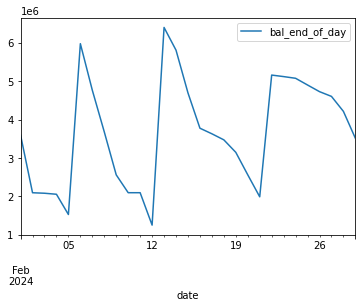

In [35]:
transactions[transactions['ATM_ID'] == 'ATM_1'][20:49].plot(x='date', y='bal_end_of_day')

In [36]:
transactions[transactions['ATM_ID'] == 'ATM_1']['cash_in'].unique()

array([      0, 6620000, 6420000])

Для первого банкомата использовались кассеты величиной 6620000 и 6420000

In [37]:
transactions[(transactions['ATM_ID'] == 'ATM_1') & (transactions['cash_in'] > 0)]['week_day'].unique()

array([1, 3, 4, 0, 2])

Пополнение происходило в разные дни с понедельника по пятницу

In [38]:
transactions[(transactions['ATM_ID'] == 'ATM_1') & (transactions['cash_in'] > 0)]

,date,ATM_ID,bal_end_of_day,cash_in,cash_out,key_rate,missed_income,CashDeliveryFixedFee,CashDeliveryPercentageFee,CashDeliveryMinFee,CashCollectionFixedFee,CashCollectionPercentageFee,CashCollectionMinFee,collection_costs,week_day
44,2024-01-23 00:00:00+00:00,ATM_1,6525100,6620000,94900,16.0,2860,1365.0,0.0001,0.0,0.0,0.0,0.0,2027,1
100,2024-02-06 00:00:00+00:00,ATM_1,5974000,6620000,646000,16.0,2619,1365.0,0.0001,0.0,0.0,0.0,0.0,2027,1
128,2024-02-13 00:00:00+00:00,ATM_1,6396300,6620000,223700,16.0,2804,1365.0,0.0001,0.0,0.0,0.0,0.0,2027,1
164,2024-02-22 00:00:00+00:00,ATM_1,5156900,6620000,1463100,16.0,2261,1365.0,0.0001,0.0,0.0,0.0,0.0,2027,3
212,2024-03-05 00:00:00+00:00,ATM_1,6458200,6620000,161800,16.0,2831,1365.0,0.0001,0.0,0.0,0.0,0.0,2027,1
252,2024-03-15 00:00:00+00:00,ATM_1,6258900,6620000,361100,16.0,2744,1365.0,0.0001,0.0,0.0,0.0,0.0,2027,4
304,2024-03-28 00:00:00+00:00,ATM_1,6306600,6620000,313400,16.0,2765,1365.0,0.0001,0.0,0.0,0.0,0.0,2027,3
348,2024-04-08 00:00:00+00:00,ATM_1,5864200,6620000,755800,16.0,2571,1365.0,0.0001,0.0,0.0,0.0,0.0,2027,0
388,2024-04-18 00:00:00+00:00,ATM_1,6303100,6620000,316900,16.0,2763,1365.0,0.0001,0.0,0.0,0.0,0.0,2027,3
460,2024-05-06 00:00:00+00:00,ATM_1,6545500,6620000,74500,16.0,2869,1365.0,0.0001,0.0,0.0,0.0,0.0,2027,0


Всего 22 пополнения

<AxesSubplot:xlabel='date'>

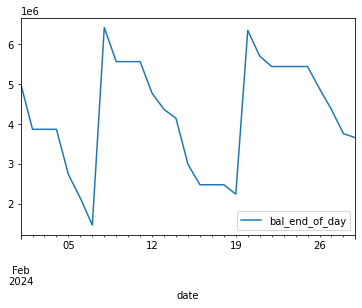

In [39]:
transactions[transactions['ATM_ID'] == 'ATM_2'][20:49].plot(x='date', y='bal_end_of_day')

In [40]:
transactions[transactions['ATM_ID'] == 'ATM_2']['cash_in'].unique()

array([      0, 7120000, 6420000])

Для первого банкомата использовались кассеты величиной 7120000 и 6420000

In [41]:
transactions[(transactions['ATM_ID'] == 'ATM_2') & (transactions['cash_in'] > 0)]['week_day'].unique()

array([2, 4, 3, 1, 5, 0])

Пополнение происходило в разные дни с понедельника по субботу

In [42]:
transactions[(transactions['ATM_ID'] == 'ATM_2') & (transactions['cash_in'] > 0)]

,date,ATM_ID,bal_end_of_day,cash_in,cash_out,key_rate,missed_income,CashDeliveryFixedFee,CashDeliveryPercentageFee,CashDeliveryMinFee,CashCollectionFixedFee,CashCollectionPercentageFee,CashCollectionMinFee,collection_costs,week_day
21,2024-01-17 00:00:00+00:00,ATM_2,7119900,7120000,100,16.0,3121,1365.0,0.0001,0.0,0.0,0.0,0.0,2077,2
29,2024-01-19 00:00:00+00:00,ATM_2,6072400,7120000,1047600,16.0,2662,1365.0,0.0001,0.0,0.0,0.0,0.0,2077,4
77,2024-01-31 00:00:00+00:00,ATM_2,6291800,7120000,828200,16.0,2758,1365.0,0.0001,0.0,0.0,0.0,0.0,2077,2
109,2024-02-08 00:00:00+00:00,ATM_2,6415700,7120000,704300,16.0,2812,1365.0,0.0001,0.0,0.0,0.0,0.0,2077,3
157,2024-02-20 00:00:00+00:00,ATM_2,6342000,7120000,778000,16.0,2780,1365.0,0.0001,0.0,0.0,0.0,0.0,2077,1
221,2024-03-07 00:00:00+00:00,ATM_2,6594900,7120000,525100,16.0,2891,1365.0,0.0001,0.0,0.0,0.0,0.0,2077,3
281,2024-03-22 00:00:00+00:00,ATM_2,6780000,7120000,340000,16.0,2972,1365.0,0.0001,0.0,0.0,0.0,0.0,2077,4
333,2024-04-04 00:00:00+00:00,ATM_2,6058100,7120000,1061900,16.0,2656,1365.0,0.0001,0.0,0.0,0.0,0.0,2077,3
365,2024-04-12 00:00:00+00:00,ATM_2,6552600,7120000,567400,16.0,2872,1365.0,0.0001,0.0,0.0,0.0,0.0,2077,4
425,2024-04-27 00:00:00+00:00,ATM_2,7020000,7120000,100000,16.0,3077,1365.0,0.0001,0.0,0.0,0.0,0.0,2077,5


Всего 22 пополнения

<AxesSubplot:xlabel='date'>

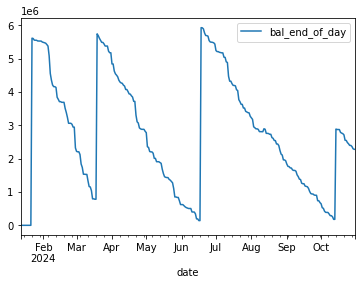

In [43]:
transactions[transactions['ATM_ID'] == 'ATM_3'].plot(x='date', y='bal_end_of_day')

In [44]:
transactions[(transactions['ATM_ID'] == 'ATM_3') & (transactions['cash_in'] > 0)]

,date,ATM_ID,bal_end_of_day,cash_in,cash_out,key_rate,missed_income,CashDeliveryFixedFee,CashDeliveryPercentageFee,CashDeliveryMinFee,CashCollectionFixedFee,CashCollectionPercentageFee,CashCollectionMinFee,collection_costs,week_day
42,2024-01-22 00:00:00+00:00,ATM_3,5609800,5610000,200,16.0,2459,2250.0,0.0001,675.0,0.0,0.0,0.0,2925,0
270,2024-03-19 00:00:00+00:00,ATM_3,5739000,5850000,111000,16.0,2516,2250.0,0.0001,675.0,0.0,0.0,0.0,2925,1
634,2024-06-18 00:00:00+00:00,ATM_3,5925000,5980000,55000,16.0,2597,2250.0,0.0001,675.0,0.0,0.0,0.0,2925,1
854,2024-08-12 00:00:00+00:00,ATM_3,2894400,2980000,85600,18.0,1427,2250.0,0.0001,675.0,0.0,0.0,0.0,2925,0
1106,2024-10-14 00:00:00+00:00,ATM_3,2884300,2940000,55700,19.0,1501,2250.0,0.0001,675.0,0.0,0.0,0.0,2925,0


In [45]:
transactions[(transactions['date'] == '2024-08-11 00:00:00+00:00') & (transactions['ATM_ID'] == 'ATM_3')]

,date,ATM_ID,bal_end_of_day,cash_in,cash_out,key_rate,missed_income,CashDeliveryFixedFee,CashDeliveryPercentageFee,CashDeliveryMinFee,CashCollectionFixedFee,CashCollectionPercentageFee,CashCollectionMinFee,collection_costs,week_day
850,2024-08-11 00:00:00+00:00,ATM_3,2805500,0,0,18.0,1384,2250.0,0.0001,675.0,0.0,0.0,0.0,0,6


По таблице и графику видно, что 
- кассеты каждый раз меняются по размерам;
- пополнение за	2024-08-12 практически не имело смысла, кассету с остатком 2805500 поменяли на полную кассету величиной 2894400
- пополнение происходило по понедельникам и вторникам
- в конце исследуемого участка, видно, что было принято решение перейти на кассеты величиной в два раза меньше, чтобы уменьшить упущенную прибыль, поскольку ключевая ставка выросла до высоких значений
- пополняли всего 5 раз за 10 месяцев

<AxesSubplot:xlabel='date'>

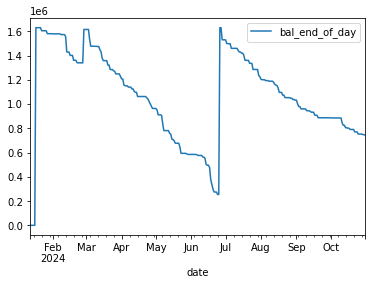

In [46]:
transactions[transactions['ATM_ID'] == 'ATM_4'].plot(x='date', y='bal_end_of_day')

In [47]:
transactions[(transactions['ATM_ID'] == 'ATM_4') & (transactions['cash_in'] > 0)]

,date,ATM_ID,bal_end_of_day,cash_in,cash_out,key_rate,missed_income,CashDeliveryFixedFee,CashDeliveryPercentageFee,CashDeliveryMinFee,CashCollectionFixedFee,CashCollectionPercentageFee,CashCollectionMinFee,collection_costs,week_day
23,2024-01-17 00:00:00+00:00,ATM_4,1630000,1630000,0,16.0,715,5250.0,0.0004,450.0,0.0,0.0045,1140.0,13237,2
191,2024-02-28 00:00:00+00:00,ATM_4,1615000,1630000,15000,16.0,708,5250.0,0.0004,450.0,0.0,0.0045,1140.0,13170,2
667,2024-06-26 00:00:00+00:00,ATM_4,1630000,1630000,0,16.0,715,5250.0,0.0004,450.0,0.0,0.0045,1140.0,13237,2


In [48]:
transactions[(transactions['date'] == '2024-02-27 00:00:00+00:00') & (transactions['ATM_ID'] == 'ATM_4')]

,date,ATM_ID,bal_end_of_day,cash_in,cash_out,key_rate,missed_income,CashDeliveryFixedFee,CashDeliveryPercentageFee,CashDeliveryMinFee,CashCollectionFixedFee,CashCollectionPercentageFee,CashCollectionMinFee,collection_costs,week_day
187,2024-02-27 00:00:00+00:00,ATM_4,1339700,0,200,16.0,587,5250.0,0.0004,450.0,0.0,0.0045,1140.0,0,1


По таблице и графику видно, что 
- кассеты величиной 1630000;
- пополнение за	2024-02-28 практически не имело смысла, кассету с остатком 1339700 поменяли на полную кассету величиной 1630000
- пополнение происходило по средам
- пополняли всего 3 раза за 10 месяцев
- очень редкие снятия

По графикам можно сделать вывод о харктере пополнений банкоматов. Банкоматы 1 и 2 пополняются часто, чуть реже раза в неделю. Банкомат 3 значительно реже: всего 5 раз за 10 месяцев. Банкомат 4 пополнялся всего 3 раза.

Сгруппируетм данные по дням и оценим различие между выходными и рабочими днями

In [49]:
columns = ['bal_end_of_day', 'cash_in', 'cash_out', 'missed_income', 'collection_costs', 'week_day']
transactions[columns].groupby(by='week_day').sum()

,bal_end_of_day,cash_in,cash_out,missed_income,collection_costs
week_day,,,,,
0,475206550,64390000,48420300,218798,24981
1,489333050,72010000,45165700,224722,24153
2,485698300,45510000,43386200,223456,51896
3,501694550,74920000,45883050,230096,22507
4,481516150,60480000,53325550,219904,18333
5,478396550,7120000,9419100,218341,2077
6,474161550,0,4235000,216427,0


Сгруппировав данные по дням недели видно, что в субботу инкасаторы привозят в сумме гораздо меньше денег, а в воскресенье инкассаторы и вовсе не работали. Также снятие наличных в субботу и воскресенье значительно снижается.

Оценим среднее значение снятых средств по дням недели для каждого банкомата в отдельности

In [50]:
avg_cash_out_atm1_per_week_day = transactions[transactions['ATM_ID'] == 'ATM_1'].groupby(by='week_day')['cash_out'].sum() / \
transactions[transactions['ATM_ID'] == 'ATM_1'].groupby(by='week_day')['cash_out'].count()
avg_cash_out_atm1_per_week_day.name = 'ATM_1'
avg_cash_out_atm1_per_week_day

week_day
0    496619.047619
1    450745.238095
2    429002.380952
3    528811.904762
4    589323.809524
5    168288.095238
6     73816.666667
Name: ATM_1, dtype: float64

In [51]:
avg_cash_out_atm2_per_week_day = transactions[transactions['ATM_ID'] == 'ATM_2'].groupby(by='week_day')['cash_out'].sum() / \
transactions[transactions['ATM_ID'] == 'ATM_2'].groupby(by='week_day')['cash_out'].count()
avg_cash_out_atm2_per_week_day.name = 'ATM_2'
avg_cash_out_atm2_per_week_day

week_day
0    585026.190476
1    537769.047619
2    535359.523810
3    479369.047619
4    602238.095238
5      2380.952381
6         0.000000
Name: ATM_2, dtype: float64

In [52]:
avg_cash_out_atm3_per_week_day = transactions[transactions['ATM_ID'] == 'ATM_3'].groupby(by='week_day')['cash_out'].sum() / \
transactions[transactions['ATM_ID'] == 'ATM_3'].groupby(by='week_day')['cash_out'].count()
avg_cash_out_atm3_per_week_day.name = 'ATM_3'
avg_cash_out_atm3_per_week_day

week_day
0    61759.523810
1    72340.476190
2    59302.380952
3    75590.476190
4    65626.190476
5    48528.571429
6    25811.904762
Name: ATM_3, dtype: float64

In [53]:
avg_cash_out_atm4_per_week_day = transactions[transactions['ATM_ID'] == 'ATM_4'].groupby(by='week_day')['cash_out'].sum() / \
transactions[transactions['ATM_ID'] == 'ATM_4'].groupby(by='week_day')['cash_out'].count()
avg_cash_out_atm4_per_week_day.name = 'ATM_4'
avg_cash_out_atm4_per_week_day

week_day
0     9459.523810
1    14519.047619
2     9340.476190
3     8682.142857
4    12467.857143
5     5066.666667
6     1204.761905
Name: ATM_4, dtype: float64

In [54]:
avg_cash_out_per_week_day = pd.concat([avg_cash_out_atm1_per_week_day, 
                                         avg_cash_out_atm2_per_week_day, 
                                         avg_cash_out_atm3_per_week_day, 
                                         avg_cash_out_atm4_per_week_day], axis=1)
avg_cash_out_per_week_day

,ATM_1,ATM_2,ATM_3,ATM_4
week_day,,,,
0,496619.047619,585026.190476,61759.523810,9459.523810
1,450745.238095,537769.047619,72340.476190,14519.047619
2,429002.380952,535359.523810,59302.380952,9340.476190
3,528811.904762,479369.047619,75590.476190,8682.142857
4,589323.809524,602238.095238,65626.190476,12467.857143
5,168288.095238,2380.952381,48528.571429,5066.666667
6,73816.666667,0.000000,25811.904762,1204.761905


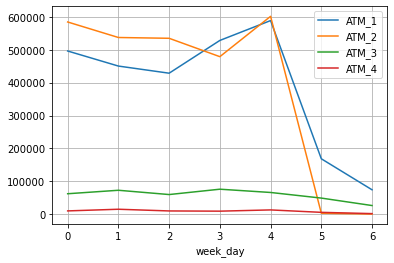

In [55]:
avg_cash_out_per_week_day.plot()
plt.grid(visible=True)

In [56]:
summary = transactions.groupby('ATM_ID').agg({
    'missed_income': 'mean',
    'collection_costs': 'mean',
    'cash_out': 'sum',
    'cash_in': 'sum',
    'bal_end_of_day': 'mean'
}).reset_index()


In [57]:
summary

,ATM_ID,missed_income,collection_costs,cash_out,cash_in,bal_end_of_day
0,ATM_1,1687.829932,151.272109,114937500,144440000,3.666365e+06
1,ATM_2,1839.258503,153.755102,115170000,151740000,3.999686e+06
2,ATM_3,1258.908163,49.744898,17176300,23360000,2.776978e+06
3,ATM_4,492.044218,134.843537,2551100,4890000,1.074001e+06


In [58]:
transactions['incasation_count'] = (transactions['cash_in'] > 0).astype(int)

In [59]:
transactions[transactions['incasation_count']>0]

,date,ATM_ID,bal_end_of_day,cash_in,cash_out,key_rate,missed_income,CashDeliveryFixedFee,CashDeliveryPercentageFee,CashDeliveryMinFee,CashCollectionFixedFee,CashCollectionPercentageFee,CashCollectionMinFee,collection_costs,week_day,incasation_count
21,2024-01-17 00:00:00+00:00,ATM_2,7119900,7120000,100,16.0,3121,1365.0,0.0001,0.0,0.0,0.0000,0.0,2077,2,1
23,2024-01-17 00:00:00+00:00,ATM_4,1630000,1630000,0,16.0,715,5250.0,0.0004,450.0,0.0,0.0045,1140.0,13237,2,1
29,2024-01-19 00:00:00+00:00,ATM_2,6072400,7120000,1047600,16.0,2662,1365.0,0.0001,0.0,0.0,0.0000,0.0,2077,4,1
42,2024-01-22 00:00:00+00:00,ATM_3,5609800,5610000,200,16.0,2459,2250.0,0.0001,675.0,0.0,0.0000,0.0,2925,0,1
44,2024-01-23 00:00:00+00:00,ATM_1,6525100,6620000,94900,16.0,2860,1365.0,0.0001,0.0,0.0,0.0000,0.0,2027,1,1
77,2024-01-31 00:00:00+00:00,ATM_2,6291800,7120000,828200,16.0,2758,1365.0,0.0001,0.0,0.0,0.0000,0.0,2077,2,1
100,2024-02-06 00:00:00+00:00,ATM_1,5974000,6620000,646000,16.0,2619,1365.0,0.0001,0.0,0.0,0.0000,0.0,2027,1,1
109,2024-02-08 00:00:00+00:00,ATM_2,6415700,7120000,704300,16.0,2812,1365.0,0.0001,0.0,0.0,0.0000,0.0,2077,3,1
128,2024-02-13 00:00:00+00:00,ATM_1,6396300,6620000,223700,16.0,2804,1365.0,0.0001,0.0,0.0,0.0000,0.0,2027,1,1
157,2024-02-20 00:00:00+00:00,ATM_2,6342000,7120000,778000,16.0,2780,1365.0,0.0001,0.0,0.0,0.0000,0.0,2077,1,1


### Часть 4 - меняем бизнес с помощью ML

Заключительная и самая интересная часть. К данному этапу у нас уже рассчитан упущенный процентный доход и расходы на инкассацию. Подумайте, как использовать ваши знания, чтобы оптимизировать процесс инкассации и уменьшить издержки.

Для данной задачи считаем, что нас устроит Service Level на уровне 90%. Это значит, что если в 9 из 10 случаев наши клиенты получают нужные им суммы, нас это устраивает.

Напоминаем, что технически в банкомат нельзя довнести сумму, и кассета меняется полностью. Соответственно, с нас берут оплату за полную кассету (если вдруг решите подойти к задаче через классическую формулу EOQ).

Вы можете подойти к задаче абсолютно любым способом и использовать все возможности ООП, Python и любых библиотек. Всё как в реальной работе, где вас никто не ограничивает.

Эффективность своего решения вы можете показать с помощью ретротестирования. Считаем, что каждая кассета может вмещать абсолютно любые суммы. Чтобы добавить реализма, вы можете считать, что деньги нужно заказывать за 3 дня до их доставки.


Представьте, что итог вашей работы состоит из 2 частей:
1) Вы презентуете своё решение руководителям банка. В этой части вы показываете, как ваше решение экономит деньги. Вы можете показать сценарий с Service Level 90% как базовый и сравнить, сколько мы сэкономим денег, если снизим его до 80% или увеличим до 95%.
2) Вы презентуете свою систему для исполнителей, а им нужно понимать за 3 дня до доставки кассеты, какую сумму заказывать, какой баланс у банкомата в какие даты должен быть. Возможно, решите ещё что-то им предоставить из данных, чтобы исполнители эффективно реализовали вашу задумку.


Используем модель временных рядов ARIMA для прогнозирования cash_out. Это позволит вам предсказать, сколько наличных потребуется в ближайшие дни.

In [60]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [61]:
transactions_ATM1 = transactions[transactions['ATM_ID'] == 'ATM_1']
data_ATM1 = pd.DataFrame(transactions_ATM1['cash_out'].values, index=transactions_ATM1['date'], columns=['cash_out'])

In [62]:
train_size = int(len(data_ATM1) * 0.8)  # 80% для тренировки
train_data_ATM1 = data_ATM1.iloc[:train_size]
validation_data_ATM1 = data_ATM1.iloc[train_size:]

In [63]:
data_ATM1

,cash_out
date,
2024-01-12 00:00:00+00:00,0
2024-01-13 00:00:00+00:00,0
2024-01-14 00:00:00+00:00,0
2024-01-15 00:00:00+00:00,0
2024-01-16 00:00:00+00:00,0
...,...
2024-10-27 00:00:00+00:00,4000
2024-10-28 00:00:00+00:00,181900
2024-10-29 00:00:00+00:00,426000


In [64]:
result = adfuller(train_data_ATM1['cash_out'])
print('p-value:', result[1])

p-value: 0.00015665760103793065


Ряд стационарен

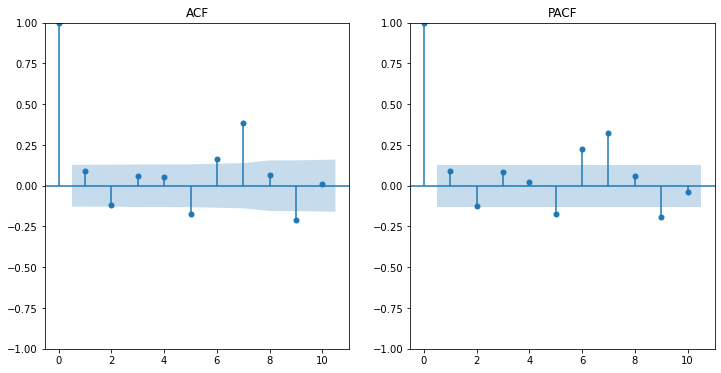

In [65]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plot_acf(train_data_ATM1['cash_out'], lags=10, ax=plt.gca())
plt.title('ACF')

plt.subplot(1, 2, 2)
plot_pacf(train_data_ATM1['cash_out'], lags=10, ax=plt.gca(), method='ywm')
plt.title('PACF')

plt.show()

p = q = 1, d = 1

In [66]:
model = SARIMAX(train_data_ATM1['cash_out'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
model_fit = model.fit()

print(model_fit.summary())

C:\Users\raili\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\raili\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:                          cash_out   No. Observations:                  235
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -3221.434
Date:                           Thu, 19 Dec 2024   AIC                           6452.867
Time:                                   04:28:18   BIC                           6469.992
Sample:                               01-12-2024   HQIC                          6459.778
                                    - 09-02-2024                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0485      0.134     -0.361      0.718      -0.312       0.215
ma.L1         -0.8941      0.077    -11.594

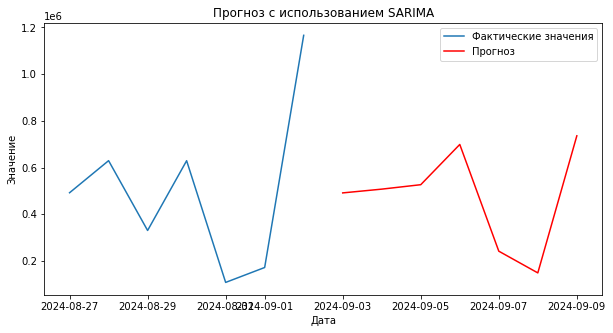

In [67]:
forecast = model_fit.forecast(steps=7)

# Визуализация фактических значений и прогноза
plt.figure(figsize=(10, 5))
plt.plot(train_data_ATM1['cash_out'][-7:], label='Фактические значения')
plt.plot(forecast, label='Прогноз', color='red')
plt.title('Прогноз с использованием SARIMA')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend()
plt.show()

Графики в целом похожи

Используя полученную модель можно прогнозировать спрос на 3 дня вперед. Отсюда можем также получить и баланс на 3 дня вперед.

В данном случае задача оптимизации заключается в том, чтобы минимизировать потери от разных источников.
- Минимизация потерь от упущенного процентного дохода требует, чтобы величина остатка баланса банкомата на конец дня была как можно меньше. Крайний случай оптимизации - это отсутствие денег на балансе банкомата на конец дня в принципе. Тогда потери от упущенного процентного дохода будут равны нулю. Тогда потребуется, чтобы инкасация привозила деньги каждый день ровно на величину предсказанного спроса с помощью модели временных рядов. При этом очевидно вырастут расходы на инкассацию, так как там имеется фиксированная часть стоимости, не зависящая от величины `cash_in`;
- Минимизация потерь от стоимости инкасации требует, чтобы пополнение банкомата было как можно реже (тут стоит отметить, что за счет этого может вырасти все компоненты затрат по аналогии с АТМ-4 за счет редкости пополнений), а величина остатка баланса также должна быть минимальной (минимизация затрат на пересчет средств в кассете).

Задача оптимизации потребует оценки величин потерь от разных источников при разных величинах кассет и разной периодичности пополнений банкомата.

In [68]:
train_size = int(len(data_ATM1) * 0.8)  # 80% для тренировки
validation_data_ATM1 = transactions_ATM1.iloc[train_size:]

In [69]:
validation_data_ATM1_forecast = validation_data_ATM1.copy()

In [70]:
validation_data_ATM1_forecast['cash_out'].count()

59

In [71]:
validation_data_ATM1_forecast['cash_out_pred'] = model_fit.forecast(steps=59).values

In [72]:
validation_data_ATM1_forecast['cash_in'] = validation_data_ATM1_forecast['cash_out_pred']

In [73]:
validation_data_ATM1_forecast['bal_end_of_day'] = validation_data_ATM1_forecast['cash_in'] - validation_data_ATM1_forecast['cash_out']

In [74]:
def money_is_out(row):
    if row['bal_end_of_day'] < 0:
        row['bal_end_of_day'] = 0
        return 1
    else:
        return 0

In [75]:
validation_data_ATM1_forecast['is_out'] = validation_data_ATM1_forecast.apply(money_is_out, axis=1)

In [76]:
validation_data_ATM1_forecast['is_out'].sum()/validation_data_ATM1_forecast['is_out'].count()

0.1694915254237288

В 17% дней в банкомате заканчивались деньги до конца дня

Сделаем величину кассеты на 20% больше спрогнозированного спроса

In [77]:
validation_data_ATM1_forecast['cash_in'] = validation_data_ATM1_forecast['cash_out_pred'] * 1.2

In [78]:
validation_data_ATM1_forecast['bal_end_of_day'] = validation_data_ATM1_forecast['cash_in'] - validation_data_ATM1_forecast['cash_out']

In [79]:
validation_data_ATM1_forecast['is_out'] = validation_data_ATM1_forecast.apply(money_is_out, axis=1)

In [80]:
validation_data_ATM1_forecast['is_out'].sum()/validation_data_ATM1_forecast['is_out'].count()

0.1016949152542373

Около 10% как и требовалось

In [81]:
validation_data_ATM1_forecast.head()

,date,ATM_ID,bal_end_of_day,cash_in,cash_out,key_rate,missed_income,CashDeliveryFixedFee,CashDeliveryPercentageFee,CashDeliveryMinFee,CashCollectionFixedFee,CashCollectionPercentageFee,CashCollectionMinFee,collection_costs,week_day,incasation_count,cash_out_pred,is_out
940,2024-09-03 00:00:00+00:00,ATM_1,479490.995586,589590.995586,110100,18.0,81,1365.0,0.0001,0.0,0.0,0.0,0.0,0,1,0,491325.829655,0
944,2024-09-04 00:00:00+00:00,ATM_1,556632.066688,608932.066688,52300,18.0,3140,1365.0,0.0001,0.0,0.0,0.0,0.0,2007,2,1,507443.388907,0
948,2024-09-05 00:00:00+00:00,ATM_1,131756.291674,631756.291674,500000,18.0,2894,1365.0,0.0001,0.0,0.0,0.0,0.0,0,3,0,526463.576395,0
952,2024-09-06 00:00:00+00:00,ATM_1,69910.809713,838610.809713,768700,18.0,2515,1365.0,0.0001,0.0,0.0,0.0,0.0,0,4,0,698842.341427,0
956,2024-09-07 00:00:00+00:00,ATM_1,144245.974253,290045.974253,145800,18.0,2443,1365.0,0.0001,0.0,0.0,0.0,0.0,0,5,0,241704.978544,0


In [82]:
validation_data_ATM1_forecast['collection_costs_pred'] = validation_data_ATM1_forecast.apply(calculate_cash_delivery_fees, axis=1)
validation_data_ATM1_forecast['missed_income_pred'] = validation_data_ATM1_forecast['bal_end_of_day'] * (validation_data_ATM1_forecast['key_rate'] / 100) * (1 / 365)

In [83]:
columns = ['collection_costs_pred', 'missed_income_pred', 'collection_costs', 'missed_income']
validation_data_ATM1_forecast[columns].sum()

collection_costs_pred     84183.387305
missed_income_pred         8444.401767
collection_costs           8028.000000
missed_income            113121.000000
dtype: float64

Видно, что намного выросли затраты на инкассацию, но снизились затраты на потерю прибыли, как и ожидалось. Чтобы найти более-менее оптимальный и реалистичный вариант можно пополнять не каждый день, а раз в 3 дня на сумму равную 3 * avg(cash_out_pred)

In [84]:
validation_data_ATM1_forecast = validation_data_ATM1.copy()
validation_data_ATM1_forecast = validation_data_ATM1_forecast.reset_index()

In [85]:
validation_data_ATM1_forecast['cash_out_pred'] = model_fit.forecast(steps=59).values

In [86]:
validation_data_ATM1_forecast['cash_in'] = validation_data_ATM1_forecast['cash_out_pred'].rolling(window=3).mean() * 3 * 0.8

In [87]:
validation_data_ATM1_forecast['cash_in'] = validation_data_ATM1_forecast['cash_in'].shift(-2).fillna(0)

In [88]:
validation_data_ATM1_forecast['cash_in'] = validation_data_ATM1_forecast['cash_in'].where((validation_data_ATM1_forecast.index) % 3 == 0, other=None).fillna(0)

In [89]:
validation_data_ATM1_forecast.head()

,index,date,ATM_ID,bal_end_of_day,cash_in,cash_out,key_rate,missed_income,CashDeliveryFixedFee,CashDeliveryPercentageFee,CashDeliveryMinFee,CashCollectionFixedFee,CashCollectionPercentageFee,CashCollectionMinFee,collection_costs,week_day,incasation_count,cash_out_pred
0,940,2024-09-03 00:00:00+00:00,ATM_1,164400,1.220186e+06,110100,18.0,81,1365.0,0.0001,0.0,0.0,0.0,0.0,0,1,0,491325.829655
1,944,2024-09-04 00:00:00+00:00,ATM_1,6367700,0.000000e+00,52300,18.0,3140,1365.0,0.0001,0.0,0.0,0.0,0.0,2007,2,1,507443.388907
2,948,2024-09-05 00:00:00+00:00,ATM_1,5867700,0.000000e+00,500000,18.0,2894,1365.0,0.0001,0.0,0.0,0.0,0.0,0,3,0,526463.576395
3,952,2024-09-06 00:00:00+00:00,ATM_1,5099000,8.713727e+05,768700,18.0,2515,1365.0,0.0001,0.0,0.0,0.0,0.0,0,4,0,698842.341427
4,956,2024-09-07 00:00:00+00:00,ATM_1,4953200,0.000000e+00,145800,18.0,2443,1365.0,0.0001,0.0,0.0,0.0,0.0,0,5,0,241704.978544


In [90]:
cassete_value = validation_data_ATM1_forecast['cash_in'].sum()/(validation_data_ATM1_forecast['cash_in'].count()//3)
cassete_value

1229846.1016407479

In [91]:
cassete_value = 1230000

In [92]:
def fill_cash_in(row):
    if row['cash_in'] > 0:
        return cassete_value
    else:
        return 0

In [93]:
validation_data_ATM1_forecast['cash_in'] = validation_data_ATM1_forecast.apply(fill_cash_in, axis=1)

In [94]:
validation_data_ATM1_forecast.head()

,index,date,ATM_ID,bal_end_of_day,cash_in,cash_out,key_rate,missed_income,CashDeliveryFixedFee,CashDeliveryPercentageFee,CashDeliveryMinFee,CashCollectionFixedFee,CashCollectionPercentageFee,CashCollectionMinFee,collection_costs,week_day,incasation_count,cash_out_pred
0,940,2024-09-03 00:00:00+00:00,ATM_1,164400,1230000,110100,18.0,81,1365.0,0.0001,0.0,0.0,0.0,0.0,0,1,0,491325.829655
1,944,2024-09-04 00:00:00+00:00,ATM_1,6367700,0,52300,18.0,3140,1365.0,0.0001,0.0,0.0,0.0,0.0,2007,2,1,507443.388907
2,948,2024-09-05 00:00:00+00:00,ATM_1,5867700,0,500000,18.0,2894,1365.0,0.0001,0.0,0.0,0.0,0.0,0,3,0,526463.576395
3,952,2024-09-06 00:00:00+00:00,ATM_1,5099000,1230000,768700,18.0,2515,1365.0,0.0001,0.0,0.0,0.0,0.0,0,4,0,698842.341427
4,956,2024-09-07 00:00:00+00:00,ATM_1,4953200,0,145800,18.0,2443,1365.0,0.0001,0.0,0.0,0.0,0.0,0,5,0,241704.978544


In [95]:
validation_data_ATM1_forecast['bal_end_of_day'] = 0

def bal_end_of_day_3_row(index):
    if validation_data_ATM1_forecast.at[index, 'cash_in'] == 0:
        return validation_data_ATM1_forecast.at[index - 1, 'bal_end_of_day'] - validation_data_ATM1_forecast.at[index, 'cash_out']
    else:
        return validation_data_ATM1_forecast.at[index, 'cash_in'] - validation_data_ATM1_forecast.at[index, 'cash_out']

for i in range(len(validation_data_ATM1_forecast)):
        validation_data_ATM1_forecast.at[i, 'bal_end_of_day'] = bal_end_of_day_3_row(i)

In [96]:
validation_data_ATM1_forecast.head()

,index,date,ATM_ID,bal_end_of_day,cash_in,cash_out,key_rate,missed_income,CashDeliveryFixedFee,CashDeliveryPercentageFee,CashDeliveryMinFee,CashCollectionFixedFee,CashCollectionPercentageFee,CashCollectionMinFee,collection_costs,week_day,incasation_count,cash_out_pred
0,940,2024-09-03 00:00:00+00:00,ATM_1,1119900,1230000,110100,18.0,81,1365.0,0.0001,0.0,0.0,0.0,0.0,0,1,0,491325.829655
1,944,2024-09-04 00:00:00+00:00,ATM_1,1067600,0,52300,18.0,3140,1365.0,0.0001,0.0,0.0,0.0,0.0,2007,2,1,507443.388907
2,948,2024-09-05 00:00:00+00:00,ATM_1,567600,0,500000,18.0,2894,1365.0,0.0001,0.0,0.0,0.0,0.0,0,3,0,526463.576395
3,952,2024-09-06 00:00:00+00:00,ATM_1,461300,1230000,768700,18.0,2515,1365.0,0.0001,0.0,0.0,0.0,0.0,0,4,0,698842.341427
4,956,2024-09-07 00:00:00+00:00,ATM_1,315500,0,145800,18.0,2443,1365.0,0.0001,0.0,0.0,0.0,0.0,0,5,0,241704.978544


In [97]:
validation_data_ATM1_forecast['is_out'] = validation_data_ATM1_forecast.apply(money_is_out, axis=1)

In [98]:
validation_data_ATM1_forecast['is_out'].sum()/validation_data_ATM1_forecast['is_out'].count()

0.11864406779661017

Получилось всего 12%

In [99]:
validation_data_ATM1_forecast['collection_costs_pred'] = validation_data_ATM1_forecast.apply(calculate_cash_delivery_fees, axis=1)
validation_data_ATM1_forecast['missed_income_pred'] = validation_data_ATM1_forecast['bal_end_of_day'] * (validation_data_ATM1_forecast['key_rate'] / 100) * (1 / 365)

In [100]:
columns = ['collection_costs_pred', 'missed_income_pred', 'collection_costs', 'missed_income']
validation_data_ATM1_forecast[columns].sum()

collection_costs_pred     28272.000000
missed_income_pred        16113.542466
collection_costs           8028.000000
missed_income            113121.000000
dtype: float64

Удалось довольно значительно снизить затраты для 88% удовлетворенности:

- До введения модели - 121000
- После - 44000

In [101]:
validation_data_ATM1_forecast = validation_data_ATM1.copy()
validation_data_ATM1_forecast = validation_data_ATM1_forecast.reset_index()

In [102]:
validation_data_ATM1_forecast['cash_out_pred'] = model_fit.forecast(steps=59).values

In [103]:
validation_data_ATM1_forecast['cash_in'] = validation_data_ATM1_forecast['cash_out_pred'].rolling(window=3).mean() * 3 * 0.75

In [104]:
validation_data_ATM1_forecast['cash_in'] = validation_data_ATM1_forecast['cash_in'].shift(-2).fillna(0)

In [105]:
validation_data_ATM1_forecast['cash_in'] = validation_data_ATM1_forecast['cash_in'].where((validation_data_ATM1_forecast.index) % 3 == 0, other=None).fillna(0)

In [106]:
validation_data_ATM1_forecast.head()

,index,date,ATM_ID,bal_end_of_day,cash_in,cash_out,key_rate,missed_income,CashDeliveryFixedFee,CashDeliveryPercentageFee,CashDeliveryMinFee,CashCollectionFixedFee,CashCollectionPercentageFee,CashCollectionMinFee,collection_costs,week_day,incasation_count,cash_out_pred
0,940,2024-09-03 00:00:00+00:00,ATM_1,164400,1.143925e+06,110100,18.0,81,1365.0,0.0001,0.0,0.0,0.0,0.0,0,1,0,491325.829655
1,944,2024-09-04 00:00:00+00:00,ATM_1,6367700,0.000000e+00,52300,18.0,3140,1365.0,0.0001,0.0,0.0,0.0,0.0,2007,2,1,507443.388907
2,948,2024-09-05 00:00:00+00:00,ATM_1,5867700,0.000000e+00,500000,18.0,2894,1365.0,0.0001,0.0,0.0,0.0,0.0,0,3,0,526463.576395
3,952,2024-09-06 00:00:00+00:00,ATM_1,5099000,8.169119e+05,768700,18.0,2515,1365.0,0.0001,0.0,0.0,0.0,0.0,0,4,0,698842.341427
4,956,2024-09-07 00:00:00+00:00,ATM_1,4953200,0.000000e+00,145800,18.0,2443,1365.0,0.0001,0.0,0.0,0.0,0.0,0,5,0,241704.978544


In [107]:
cassete_value = validation_data_ATM1_forecast['cash_in'].sum()/(validation_data_ATM1_forecast['cash_in'].count()//3)
cassete_value

1152980.720288201

In [108]:
cassete_value = 1150000

In [109]:
def fill_cash_in(row):
    if row['cash_in'] > 0:
        return cassete_value
    else:
        return 0

In [110]:
validation_data_ATM1_forecast['cash_in'] = validation_data_ATM1_forecast.apply(fill_cash_in, axis=1)

In [111]:
validation_data_ATM1_forecast.head()

,index,date,ATM_ID,bal_end_of_day,cash_in,cash_out,key_rate,missed_income,CashDeliveryFixedFee,CashDeliveryPercentageFee,CashDeliveryMinFee,CashCollectionFixedFee,CashCollectionPercentageFee,CashCollectionMinFee,collection_costs,week_day,incasation_count,cash_out_pred
0,940,2024-09-03 00:00:00+00:00,ATM_1,164400,1150000,110100,18.0,81,1365.0,0.0001,0.0,0.0,0.0,0.0,0,1,0,491325.829655
1,944,2024-09-04 00:00:00+00:00,ATM_1,6367700,0,52300,18.0,3140,1365.0,0.0001,0.0,0.0,0.0,0.0,2007,2,1,507443.388907
2,948,2024-09-05 00:00:00+00:00,ATM_1,5867700,0,500000,18.0,2894,1365.0,0.0001,0.0,0.0,0.0,0.0,0,3,0,526463.576395
3,952,2024-09-06 00:00:00+00:00,ATM_1,5099000,1150000,768700,18.0,2515,1365.0,0.0001,0.0,0.0,0.0,0.0,0,4,0,698842.341427
4,956,2024-09-07 00:00:00+00:00,ATM_1,4953200,0,145800,18.0,2443,1365.0,0.0001,0.0,0.0,0.0,0.0,0,5,0,241704.978544


In [112]:
validation_data_ATM1_forecast['bal_end_of_day'] = 0

def bal_end_of_day_3_row(index):
    if validation_data_ATM1_forecast.at[index, 'cash_in'] == 0:
        return validation_data_ATM1_forecast.at[index - 1, 'bal_end_of_day'] - validation_data_ATM1_forecast.at[index, 'cash_out']
    else:
        return validation_data_ATM1_forecast.at[index, 'cash_in'] - validation_data_ATM1_forecast.at[index, 'cash_out']

for i in range(len(validation_data_ATM1_forecast)):
        validation_data_ATM1_forecast.at[i, 'bal_end_of_day'] = bal_end_of_day_3_row(i)

In [113]:
validation_data_ATM1_forecast.head()

,index,date,ATM_ID,bal_end_of_day,cash_in,cash_out,key_rate,missed_income,CashDeliveryFixedFee,CashDeliveryPercentageFee,CashDeliveryMinFee,CashCollectionFixedFee,CashCollectionPercentageFee,CashCollectionMinFee,collection_costs,week_day,incasation_count,cash_out_pred
0,940,2024-09-03 00:00:00+00:00,ATM_1,1039900,1150000,110100,18.0,81,1365.0,0.0001,0.0,0.0,0.0,0.0,0,1,0,491325.829655
1,944,2024-09-04 00:00:00+00:00,ATM_1,987600,0,52300,18.0,3140,1365.0,0.0001,0.0,0.0,0.0,0.0,2007,2,1,507443.388907
2,948,2024-09-05 00:00:00+00:00,ATM_1,487600,0,500000,18.0,2894,1365.0,0.0001,0.0,0.0,0.0,0.0,0,3,0,526463.576395
3,952,2024-09-06 00:00:00+00:00,ATM_1,381300,1150000,768700,18.0,2515,1365.0,0.0001,0.0,0.0,0.0,0.0,0,4,0,698842.341427
4,956,2024-09-07 00:00:00+00:00,ATM_1,235500,0,145800,18.0,2443,1365.0,0.0001,0.0,0.0,0.0,0.0,0,5,0,241704.978544


In [114]:
validation_data_ATM1_forecast['is_out'] = validation_data_ATM1_forecast.apply(money_is_out, axis=1)

In [115]:
validation_data_ATM1_forecast['is_out'].sum()/validation_data_ATM1_forecast['is_out'].count()

0.1694915254237288

Получилось всего 17%

In [116]:
validation_data_ATM1_forecast['collection_costs_pred'] = validation_data_ATM1_forecast.apply(calculate_cash_delivery_fees, axis=1)
validation_data_ATM1_forecast['missed_income_pred'] = validation_data_ATM1_forecast['bal_end_of_day'] * (validation_data_ATM1_forecast['key_rate'] / 100) * (1 / 365)

In [117]:
columns = ['collection_costs_pred', 'missed_income_pred', 'collection_costs', 'missed_income']
validation_data_ATM1_forecast[columns].sum()

collection_costs_pred     28120.000000
missed_income_pred        13667.515068
collection_costs           8028.000000
missed_income            113121.000000
dtype: float64

Снижение потерь за счет уменьшения кассеты и снижения удовлетворенности снизил затраты совсем незначительно

В качестве продолжения исследования можно было бы продолжить подбор оптимального числа дней между пополнениями банкоматов

Также надо построить соответствующие модели временных рядов и для других ATM, и проанализировать и их поведение

### Заключение

Решение вы можете предоставить любым способом: репозиторий GitHub, Google Colab, конвертированный IPython Notebook в PDF и т. п.

По срокам вас не ограничивают, но учитывайте, что в это же время задачу могут решать и другие кандидаты. Таким образом, вы участвуете в конкурсе с ними.